## Imports

In [1]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import seaborn as sns

In [2]:
# Function definitions
def title_apply(df, col, titles):
    for i in titles:
        if i in df[col]:
            return i

### Reading the data

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

df_full = pd.concat([df_train[df_test.columns],df_test])

### Featuring Engineering with full data
- Transforming categorical to numeric

In [4]:
df_full['Sex'] = pd.Categorical(df_full['Sex'])
df_full['Sex_n'] = df_full['Sex'].cat.codes

df_full['Embarked'] = pd.Categorical(df_full['Embarked'])
df_full['Embarked_n'] = df_full['Embarked'].cat.codes

- Fill age with mean value and fare

In [5]:
# Age
df_full['Age'] = df_full['Age'].round(0)
df_full['Age'] = df_full['Age'].fillna(round(df_full['Age'].mean(),0))

# Fare
df_full['Fare'] = df_full['Fare'].fillna(0)

- Title

In [6]:
# Defining titles list
titles = []

for name in df_full['Name']:
    splitted = name.split(' ')
    for i in splitted:
        if '.' in i:
            titles.append(i)
            
titles = list(set(titles))
titles.remove('L.')
titles

['Countess.',
 'Mr.',
 'Lady.',
 'Major.',
 'Mlle.',
 'Master.',
 'Mme.',
 'Dona.',
 'Sir.',
 'Ms.',
 'Jonkheer.',
 'Don.',
 'Mrs.',
 'Capt.',
 'Col.',
 'Miss.',
 'Rev.',
 'Dr.']

In [7]:
# Applying new title column
df_full['Title'] = df_full.apply(lambda x: title_apply(x, 'Name', titles), axis=1)

# Categorical to numerical
df_full['Title'] = pd.Categorical(df_full['Title'])
df_full['Title_n'] = df_full['Title'].cat.codes

- Total size of family

In [8]:
df_full['Total_Family_Size'] = df_full['SibSp'] + df_full['Parch'] + 1

df_full['Family_Fare'] = df_full['Fare'] / df_full['Total_Family_Size']

- Ticket feature

In [9]:
df_full['Ticket'] = df_full['Ticket'].str.replace('[/. 0-9]','', regex=True)
df_full['Ticket'] = df_full.apply(lambda x: 'Numeric_Ticket' if x['Ticket'] == '' else x['Ticket'], axis=1)

In [10]:
df_full['Ticket'] = pd.Categorical(df_full['Ticket'])
df_full['Ticket_n'] = df_full['Ticket'].cat.codes

- Cabin Feature

In [11]:
df_full['Cabin'] = df_full['Cabin'].fillna('Z')
df_full['Cabin'] = df_full['Cabin'].str[0]

In [12]:
df_full['Cabin'] = pd.Categorical(df_full['Cabin'])
df_full['Cabin_n'] = df_full['Cabin'].cat.codes

In [15]:
df_full.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_n,Embarked_n,Title,Title_n,Total_Family_Size,Family_Fare,Ticket_n,Cabin_n
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A,7.2500,Z,S,1,2,Mr.,13,2,3.62500,0,8
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC,71.2833,C,C,0,0,Mrs.,14,2,35.64165,12,2
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STONO,7.9250,Z,S,0,2,Miss.,10,1,7.92500,28,8
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,Numeric_Ticket,53.1000,C,S,0,2,Mrs.,14,2,26.55000,11,2
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,Numeric_Ticket,8.0500,Z,S,1,2,Mr.,13,1,8.05000,11,8


In [20]:
df_train = df_train[['PassengerId','Survived']]
df_train = df_full.merge(df_train, on='PassengerId', how='inner')

### Feature selection and model training

In [23]:
features = ['Pclass','Sex_n','Age','SibSp','Parch','Fare','Embarked_n','Title_n','Total_Family_Size','Family_Fare','Ticket_n','Cabin_n']

train_X = df_train[features]
train_y = df_train['Survived']

<AxesSubplot:>

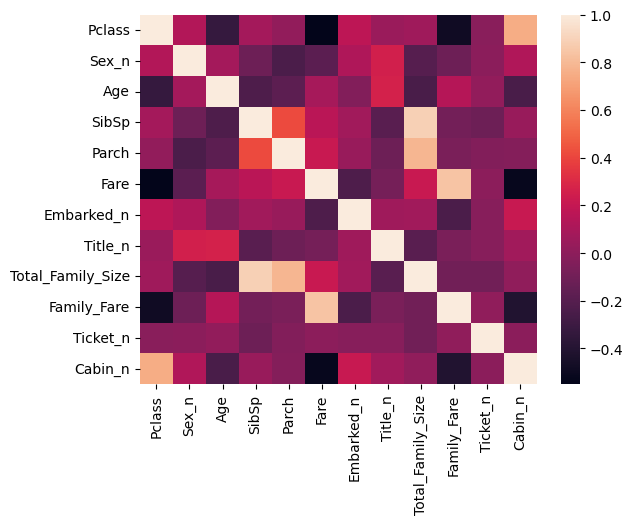

In [24]:
sns.heatmap(train_X.corr())

In [25]:
model = DecisionTreeClassifier(random_state=28)
model.fit(train_X, train_y)

model_gauss = GaussianProcessClassifier(random_state=28)
model_gauss.fit(train_X, train_y)

model_rf = RandomForestClassifier(random_state=28)
model_rf.fit(train_X, train_y)

model_ada = AdaBoostClassifier(random_state=28)
model_ada.fit(train_X, train_y)

AdaBoostClassifier(random_state=28)

In [26]:
train_predictions = pd.Series(model.predict(train_X))
train_predictions = train_predictions.rename('Predicted')

train_predictions_gauss = pd.Series(model_gauss.predict(train_X))
train_predictions_gauss = train_predictions_gauss.rename('Predicted')

train_predictions_rf = pd.Series(model_rf.predict(train_X))
train_predictions_rf = train_predictions_rf.rename('Predicted')

train_predictions_ada = pd.Series(model_ada.predict(train_X))
train_predictions_ada = train_predictions_ada.rename('Predicted')

In [27]:
predicted = pd.concat([df_train['Survived'], train_predictions], axis=1)
predicted['Result'] = predicted.apply(lambda x: x['Survived'] == x['Predicted'], axis=1)
predicted_gauss = pd.concat([df_train['Survived'], train_predictions_gauss], axis=1)
predicted_gauss['Result'] = predicted_gauss.apply(lambda x: x['Survived'] == x['Predicted'], axis=1)
predicted_rf = pd.concat([df_train['Survived'], train_predictions_rf], axis=1)
predicted_rf['Result'] = predicted_rf.apply(lambda x: x['Survived'] == x['Predicted'], axis=1)
predicted_ada = pd.concat([df_train['Survived'], train_predictions_ada], axis=1)
predicted_ada['Result'] = predicted_ada.apply(lambda x: x['Survived'] == x['Predicted'], axis=1)

correct_predictions = predicted['Result'].value_counts()[True]
total = predicted['Result'].count()
correct_predictions_gauss = predicted_gauss['Result'].value_counts()[True]
total_gauss = predicted_gauss['Result'].count()
correct_predictions_rf = predicted_rf['Result'].value_counts()[True]
total_rf = predicted_rf['Result'].count()
correct_predictions_ada = predicted_ada['Result'].value_counts()[True]
total_ada = predicted_ada['Result'].count()

model_accuracy = correct_predictions / total
model_accuracy_gauss = correct_predictions_gauss / total_gauss
model_accuracy_rf = correct_predictions_rf / total_rf
model_accuracy_ada = correct_predictions_ada / total_ada
print(f'Model accuracy is : {model_accuracy}')
print(f'Model accuracy for gauss is : {model_accuracy_gauss}')
print(f'Model accuracy for rf is : {model_accuracy_rf}')
print(f'Model accuracy for ada is : {model_accuracy_ada}')

Model accuracy is : 0.9887766554433222
Model accuracy for gauss is : 0.9730639730639731
Model accuracy for rf is : 0.9887766554433222
Model accuracy for ada is : 0.8473625140291807


In [29]:
df_test = df_test['PassengerId']
df_test = df_full.merge(df_test, on='PassengerId', how='inner')

In [32]:
# Test Feature selection
test_X = df_test[features]

# Predictions
test_predictions = model_ada.predict(test_X)

In [33]:
df_submission = pd.concat([df_test['PassengerId'], pd.Series(test_predictions)], axis=1)

In [34]:
df_submission = df_submission.rename(columns={0:'Survived'})
df_submission.to_csv("titanic_results_ada.csv", header=True, index=False)